# Week 07 Group 40

## Import necessary modules

In [1]:
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tensorflow.keras import Model

## Load the dataset

In [2]:
(input_train, label_train), (input_test, label_test) = tf.keras.datasets.fashion_mnist.load_data()
print("min = {} max = {}".format(input_train.min(),input_train.max()))

4423680/4422102 [==============================] - 0s 0us/step
min = 0 max = 255


## Print some images with their lables

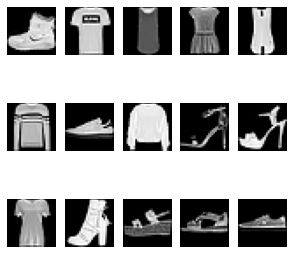

In [3]:
fig, ax = plt.subplots(3,5, figsize = (5,5))
ax = ax.flatten()
for i in range(15):
    img = input_train[i]

    ax[i].imshow(img, cmap='gray')
    ax[i].axis("off")

## Input-Pipeline

In [4]:
def preprocess(input, label):
    input = input/255
    input = tf.reshape(input,(28,28,1))
    print(input)
    return (input, label)

#prepare our data (normalize, reshaping to 1 color-channel, shuffle, batch and prefetch)
input_train = tf.data.Dataset.from_tensor_slices(input_train)
label_train = tf.data.Dataset.from_tensor_slices(label_train)
input_test = tf.data.Dataset.from_tensor_slices(input_test)
label_test = tf.data.Dataset.from_tensor_slices(label_test)
train_ds = tf.data.Dataset.zip((input_train, label_train)) 
test_ds = tf.data.Dataset.zip((input_test, label_test))
train_ds = train_ds.map(preprocess)
test_ds = test_ds.map(preprocess)
train_ds =   (tf.data.Dataset.shuffle(train_ds,buffer_size = 100000, reshuffle_each_iteration=True).batch(64)).prefetch(3)
test_ds =   (tf.data.Dataset.shuffle(test_ds,buffer_size = 100000, reshuffle_each_iteration=True).batch(64)).prefetch(3)

Tensor("Reshape:0", shape=(28, 28, 1), dtype=float32)
Tensor("Reshape:0", shape=(28, 28, 1), dtype=float32)


## Convolutional autoencoder

### Encoder

In [5]:
class Encoder(Model):
    def __init__(self):
        #define embedding size
        embedding_size = 20
        super(Encoder, self).__init__()
        
        self.conv_layer1 = tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, padding = "same", activation = "relu", input_shape = (28,28,1))
        self.pool_layer1 = tf.keras.layers.MaxPool2D(pool_size = 2, padding = "same")
        
        self.conv_layer2 = tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, padding = "same", activation = "relu")
        self.pool_layer2 = tf.keras.layers.MaxPool2D(pool_size = 2, padding = "same")

        self.conv_layer3 = tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, padding = "same", activation = "relu")
        self.flat_layer = tf.keras.layers.Flatten()
        
        self.dense_layer = tf.keras.layers.Dense(units = embedding_size, activation = "sigmoid")

    def __call__(self, x):
        x = self.conv_layer1(x)
        x = self.pool_layer1(x)

        x = self.conv_layer2(x)
        x = self.pool_layer2(x)

        x = self.conv_layer3(x)

        x = self.flat_layer(x)
        
        x = self.dense_layer(x)
        return x

### Decoder

In [6]:
class Decoder(tf.keras.Model):
    def __init__(self):
        super(Decoder, self).__init__()

        self.dense_layer = tf.keras.layers.Dense(units = 49, activation = None)
        self.reshape_layer = tf.keras.layers.Reshape(target_shape=(7,7,1))
        self.conv_layer1 = tf.keras.layers.Conv2DTranspose(filters = 32 , kernel_size = 3, strides = (2,2), padding = "same", activation = None)
        self.conv_layer2 = tf.keras.layers.Conv2DTranspose(filters = 64, kernel_size = 3, strides = (2,2), padding = "same", activation = None)
        self.conv_layer3 = tf.keras.layers.Conv2DTranspose(filters = 64, kernel_size = 3, strides = 1, padding = "same", activation = None)


        self.output_layer = tf.keras.layers.Conv2D(filters = 1, kernel_size= 3, padding = "same", activation = "sigmoid")

    def __call__(self, x):
        
        x = self.dense_layer(x)
        x = self.reshape_layer(x)
        x = self.conv_layer1(x)
        x = self.conv_layer2(x)
        x = self.conv_layer3(x)
        #print("after conv_3: {}".format(x.shape))

        x = self.output_layer(x)
        return x

### Autoencoder

In [7]:
class Autoencoder(tf.keras.Model):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.encoder = Encoder()

        self.decoder = Decoder()

    def __call__(self, x):
        x = self.encoder(x)

        x = self.decoder(x)
        
        #print("output autodecoder: {}".format(x.shape))
        return x

## Define training and test step

In [8]:
def train_step(model, input, loss_function, optimizer):
    with tf.GradientTape() as tape:
        expectation = model(input)
        train_accuracy =  1
        loss = loss_function(input, expectation)
        gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss, train_accuracy

#test for loss and retrieve images for comparison later
def test(model, test_data, loss_function):
    imgs = []
    test_losses_total = []
    # Compute and return loss and accuracy of Test-data
    for (input, target) in test_data:
        expectation = model( input)
        test_loss = loss_function(input, expectation)
        #save input image and reconstructed image for accuracy analysis
        imgs.append((input, expectation))
        test_losses_total.append(test_loss)
    
    # take the mean of all losses
    test_losses_total = np.mean(test_losses_total)
    return test_losses_total, imgs

## Train the Model for 20 epochs

In [9]:
#use local GPU to speed up training significantly
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [11]:
# if quoted out, so as to not reload our model and test-metrics


# initialize the model
model = Autoencoder()
# use MeanSquaredError as loss function
loss_function = tf.keras.losses.MeanSquaredError()
# use adam as optimizer
learning_rate = 0.0001
optimizer = tf.keras.optimizers.Adam(learning_rate)
# lists for plotting later
test_loss_list = []
test_accuracy_list = []

train_loss_list = []
train_accuracy_list = []

In [12]:
# we train for the predefined number of epochs
num_epochs = 10

for step in range(num_epochs):
    # reset average for each step
    changing_average = []
    # train the model with the training data
    for (input, _) in train_ds:
        # perform training step and store the loss and accuracy of step
        with tf.device('/device:GPU:0'):
          train_loss, train_accuracy = train_step(model, input, loss_function, optimizer)
          changing_average.append(train_loss)

    # compute mean loss of trainingcycle
    train_loss_list.append(np.mean(changing_average))
    
    
    # test on the test data
    with tf.device('/device:GPU:0'):
      test_loss, test_accuracy = test(model, test_ds, loss_function)
      test_loss_list.append(test_loss)
      test_accuracy_list.append(test_accuracy)
    print("Epoch: " + str(step + 1))
    print("Training Loss: " + str(train_loss_list[-1]))
    
   
#model.save_weights('saved_model_weights_autoencoder')
#model.save_weights('saved_model_weights_autoencoder.h5')

Epoch: 1
Training Loss: 0.055377457
Epoch: 2
Training Loss: 0.028685471
Epoch: 3
Training Loss: 0.025116509
Epoch: 4
Training Loss: 0.023737686
Epoch: 5
Training Loss: 0.022786897
Epoch: 6
Training Loss: 0.022060666
Epoch: 7
Training Loss: 0.021562828
Epoch: 8
Training Loss: 0.021174494
Epoch: 9
Training Loss: 0.02088257
Epoch: 10
Training Loss: 0.020621391


## Take a look at the accuracy and loss during training and on the test data

In [13]:
print(train_loss_list)
print(test_loss_list)

[0.055377457, 0.028685471, 0.025116509, 0.023737686, 0.022786897, 0.022060666, 0.021562828, 0.021174494, 0.02088257, 0.020621391]
[0.032710064, 0.026143761, 0.024227431, 0.023300605, 0.022537617, 0.021833556, 0.021363253, 0.021096831, 0.02083465, 0.020573763]


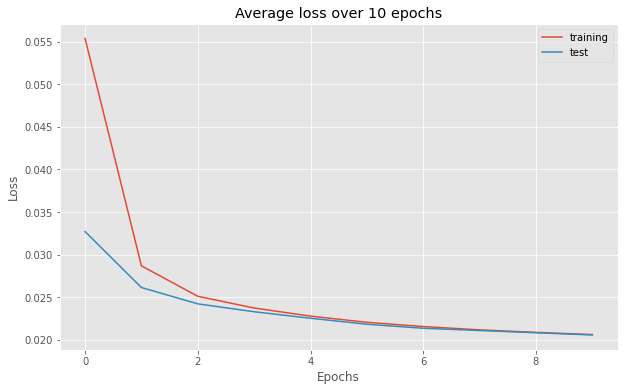

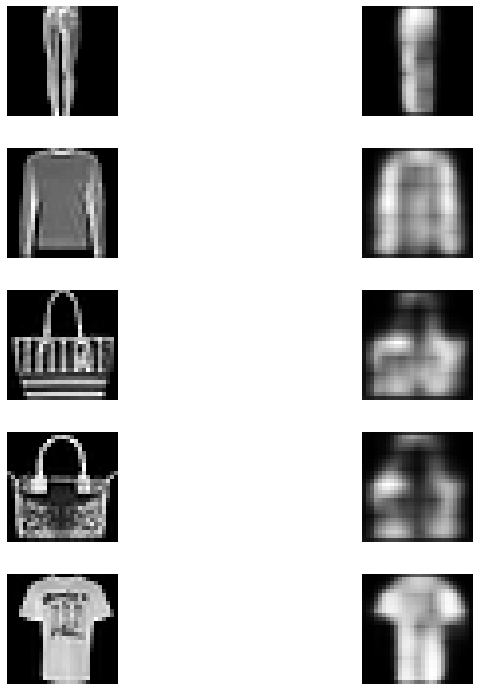

In [14]:
# plot the loss
plt.style.use('ggplot')
fig1, ax1 = plt.subplots(nrows=1, ncols=1, figsize = (10, 6))

ax1.plot(train_loss_list, label='training')
ax1.plot(test_loss_list, label='test')
ax1.set(ylabel='Loss', xlabel='Epochs', title=f'Average loss over {num_epochs} epochs')
ax1.legend()

# compare the input images and reconstructed images
for (input, expectation) in test_accuracy:
  #reduce dimensionality for plotting
  input = tf.squeeze(input)
  expectation = tf.squeeze(expectation)
    
  fig, ax = plt.subplots(5,2, figsize = (10,10))
  fig.tight_layout()
  for i in range(5):
    ax[i][0].imshow(input[i], cmap = "gray")
    ax[i][0].axis('off')
    ax[i][1].imshow(expectation[i], cmap = "gray")
    ax[i][1].axis('off')

  plt.show()
         
  break

## Latent space analysis

In [17]:
from sklearn.manifold import TSNE 
#use TSNE with 2 components for output-dimensionality
tsne = TSNE(n_components=2, random_state=0)
embeddings = []
# setup lists to correctly include label names with the embeddings
label_names = ["top", "trouser", "pullover", "dress", "coat", "sandal", "shirt", "sneaker", "bag", "boots"]
embedding_labels = []
with tf.device('/device:GPU:0'):
  for (input , label) in test_ds.unbatch().batch(1).take(1000):
    #compute the embbedings and corresponding labels
    embeddings.append(model.encoder(input))
    embedding_labels.append(label_names[int(label)])
  #transform embeddings to correct size to be used for TSNE
  tsne_embeddings_prep = [tf.reshape(img, (-1)) for img in embeddings]
  tsne_embeddings = tsne.fit_transform(tsne_embeddings_prep)
print(len(tsne_embeddings))
print(tsne_embeddings[1])

1000
[-0.8282408 -0.9134979]


In [18]:
from bokeh.models import ColumnDataSource
from bokeh.palettes import Spectral10
from bokeh.io import output_notebook
from bokeh.plotting import figure, show, output_file
from bokeh.transform import factor_cmap

output_notebook()

p = figure(toolbar_location="below",
           title="Embeddings of first 1000 Test Images")

source = ColumnDataSource(data=dict(x1=tsne_embeddings[:,0],
                                    x2=tsne_embeddings[:,1],
                                    names=embedding_labels))

p.scatter(x="x1", y="x2", size=6, source=source, fill_color=factor_cmap('names', palette=Spectral10, factors=label_names), fill_alpha=0.6, line_color=factor_cmap('names', palette=Spectral10, factors=label_names), legend_field='names') 

show(p)

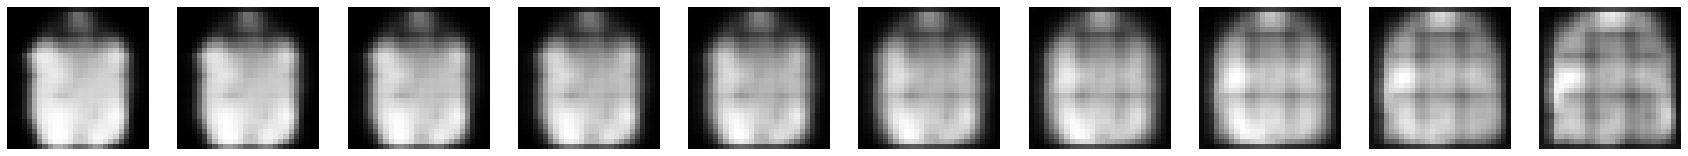

In [21]:
#define how finegrained interpolatio should be
n_imgs = 10
def interpolate(embedding1, embedding2, n_steps=n_imgs):
  #get evenly spaced ratios between 0 and 1 with step-size: 1/n_steps
  ratios = np.linspace(0, 1, num=n_steps)
  #compute all the embedding-interpolations 
  interpolation_list = [(1.0 - ratio) * embedding1 + ratio * embedding2 for ratio in ratios]
  return interpolation_list
#compute interpolation between two (randomly)-choosen embeddings
interpolations = interpolate(embeddings[1], embeddings[5])
# plot the interpolated images
fig, ax = plt.subplots(1, n_imgs, figsize = (30,30))
for i in range(n_imgs):
  img = model.decoder(interpolations[i])
  ax[i].imshow(tf.squeeze(img), cmap = "gray")
  ax[i].axis('off')
    

##Evaluation

As you can see we get a fairly well seperated Clustering. We can observe that classes that are generally similar in shape (e.g. Pullover, dress and shirt) are also clustered in the same region. This makes it harder to differentiate those. Classes that have a rather unique appearence, on the other hand, are nicely seperated from other classes and easily distinguishable.
All in all this is probably what you would expect when thinking about shape-similarity across 10 classes.